# 🛰️🌿Predict crops using EarthDaily simulated constellation

The idea of this hackathon  is to use the **EarthDaily Simulated dataset** to predict the 2019 crops in the current season (as if we were july 1st).
The dataset was pregenerated using the earthdaily python package (with relies on the EarthData Store) and the code is available in this notebook.

We have three different years (2018, 2019 and 2020) and our workflow train from a specific year (2018 or 2020) only on spectral bands to predict an independent year (2019 being Nebraska's wettest summer). We challenge you to have the maximum accuracy to **predict year 2019** by having only **data up to july 1st** (so a month and a half of data, from may 15th to july 1st).

## 🎯 Goal
Have the **highest accuracy to predict soybeans and corn for year 2019**. This can be done by enhancing the training of the algorithms, by adding new features (weather, SAR...) or anything else except giving the ground truth for year 2019 of course ! 



## Environment Setup

Please refer to the README.md for setting up the environment for this notebook 

### Import and Init Env

In [2]:
import os

# If using LightningAI, change the current working directory to the directory containing this notebook. 
REPO_DIR = "/teamspace/studios/this_studio/eda-bids-hackathon-prep/"  # Adjust as appropriate
if os.path.exists(REPO_DIR):
    os.chdir(os.path.join(REPO_DIR, "edagro-crop-detection"))

# If you encounter a warning regarding gdal mising GDAL_DATA, run the following 
if os.environ.get('CONDA_PREFIX') is not None: 
    if os.environ.get('GDAL_DATA') is None: os.environ["CONDA_PREFIX"] + r"\Library\share\gdal"
    if os.environ.get('PROJ_LIB') is None: os.environ["CONDA_PREFIX"] + r"\Library\share\proj"

In [2]:
from matplotlib import pyplot as plt

from earthdaily import (
    earthdatastore,
)  # if you consider to generate the dataset, warning it takes about 1 or 2 hours.
from sklearn import metrics
import numpy as np
import xarray as xr
import rioxarray as rxr
import pandas as pd
import geopandas as gpd
from dotenv import load_dotenv
import utils  # specific codes for this hackathon

# Load EDS credentials from .env file
load_dotenv()

## Generate dataset from the EarthDaily Simulation

The **Simulated EarthDaily dataset** is a simulation using various Sensors (Venus, Sentinel-2, Landsat, Modis) in order to have a cloudless version of what we will be able to generate when **EarthDaily constellation** will be here : 5m spatial resolution on most of VNIR bands, daily revisit, radiometric scientific grade quality...
As it is cloudless, it is an Analytics Ready Product. There can be some artefacts (like some noise patterns at some dates where few data were available)  or in urban areas (this dataset is best suitable for the agriculture).

### Ground truth
The crops dataset (polygon and label) for each year is the extent extract from the [Crop Sequence Boundaries](https://www.nass.usda.gov/Research_and_Science/Crop-Sequence-Boundaries/index.php) (CSB). You can got this data directly via `utils.crops_layer(2020)` for year 2020.

In [3]:
# To generate the dataset for a specific year
year = 2020
df = utils.crops_layer(year)
bbox = df.to_crs(4326).total_bounds.tolist()
# Add crops names to the dataframe
crops_df = pd.DataFrame(
    list(utils.y_labels.values()),
    list(utils.y_labels.keys()),
    columns=["crop"],
)
df = df.merge(crops_df, how="left", left_on="R20", right_index=True)

Explore the dataset for this year

In [27]:
df.explore(column="crop", popup=True, tiles="CartoDB positron", cmap="Set1")

Here we generate the training data of the year defined earlier (warning it takes around 30 minutes per year).
The earthdaily python package relies on the EarthData Store.
As it takes about 2 hours to generate the dataset (for the 3 years), **you provide you a pregenerated dataset for the Hackathon**. But this code has been used to generated the data you'll have.

In [5]:
generate_dataset = False
days_interval = 5  # one information every x days (default=5)

if generate_dataset:
    eds = earthdatastore.Auth()
    items = eds.search(
        "earthdaily-simulated-cloudless-l2a-cog-edagro",
        bbox=bbox,
        datetime=[f"{year}-05-15", f"{year}-10-15"], # it excludes 1st july
        prefer_alternate="download",
        query=dict(instruments={"contains": "vnir"}),
    )
    
    # get only one item every 5 days  (days_interval)
    items = [items[i] for i in np.arange(0, len(items), days_interval)]
    datacube_sr = earthdatastore.datacube(
        items,
        bbox=bbox,
        assets={
            "image_file_B": "blue",
            "image_file_G": "green",
            "image_file_Y": "yellow",
            "image_file_R": "red",
            "image_file_RE1": "redege1",
            "image_file_RE2": "redege2",
            "image_file_RE3": "redege3",
            "image_file_NIR": "nir",
        },
    )

    for data_var in datacube_sr:
        break
        data_var_nc = f"data/eds/{year}/{data_var}.nc"
        if os.path.exists(data_var_nc):
            continue
        os.makedirs(f"data/eds/{year}", exist_ok=True)
        ds_stats = earthdatastore.cube_utils.zonal_stats_numpy(
            datacube_sr[[data_var]], df
        )
        ds_stats.to_netcdf(data_var_nc)

## Plot time series per polygon
`utils.X_year` function returns the mean values for each polygon and per date.

Here we plot polygon from index 500, 1000, 1500 and 2000.

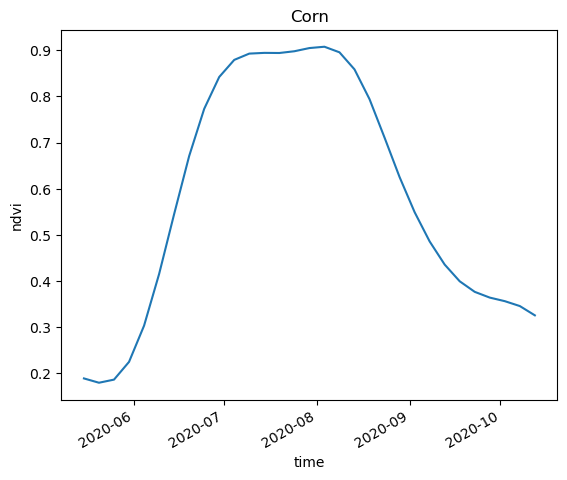

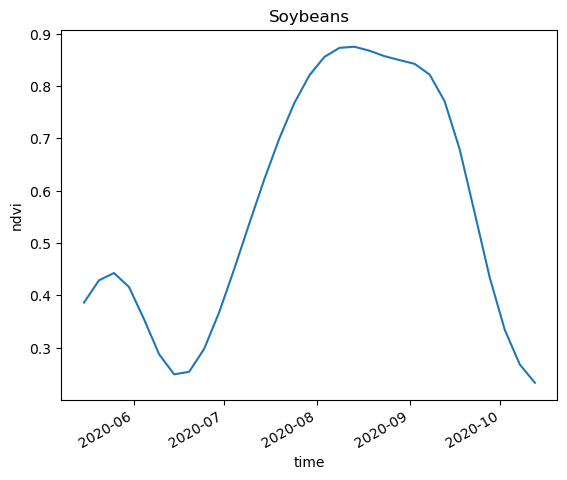

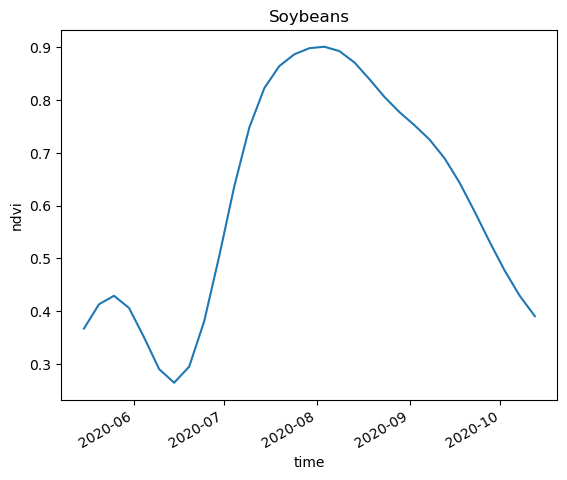

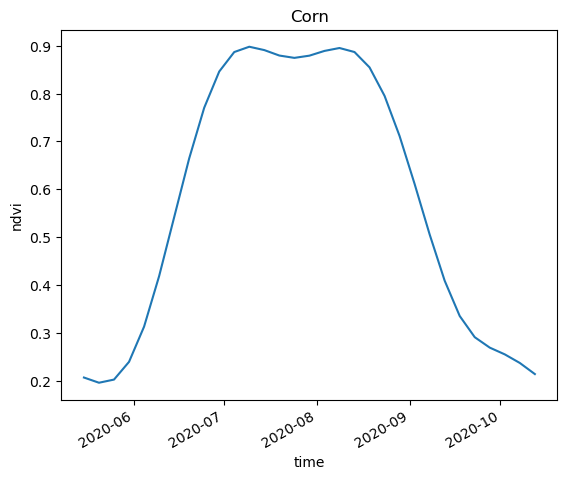

In [6]:
ds = utils.X_year(year, to_numpy=False, return_feature_index=False)
for feature_idx in [500, 1000, 1500, 2000]:
    ds["ndvi"].isel(feature=feature_idx, stats=0).plot()
    plt.title(utils.y_labels[df.iloc[feature_idx][f"R{str(year)[2:]}"]])
    plt.show()

## Available dates

In [7]:
print(f'These are available dates for year {year} : ')
print(ds.time.dt.strftime('%Y-%m-%d').data)

These are available dates for year 2020 : 
['2020-05-15' '2020-05-20' '2020-05-25' '2020-05-30' '2020-06-04'
 '2020-06-09' '2020-06-14' '2020-06-19' '2020-06-24' '2020-06-29'
 '2020-07-04' '2020-07-09' '2020-07-14' '2020-07-19' '2020-07-24'
 '2020-07-29' '2020-08-03' '2020-08-08' '2020-08-13' '2020-08-18'
 '2020-08-23' '2020-08-28' '2020-09-02' '2020-09-07' '2020-09-12'
 '2020-09-17' '2020-09-22' '2020-09-27' '2020-10-02' '2020-10-07'
 '2020-10-12']


# Generate training/testing data
We have data from **may 15th to october 15th**. But in order to predict the crop during the season, we chose an `end_datetime`, here for the **july 1st**.

In [8]:
# We suppose we have data only up to july 1st.
end_datetime = "07-01"  # july 1st
# you can go up to 10-15 (october 15th)
X_18, y_18, y_18_indices = utils.X_y(2018, end_datetime=end_datetime, return_indices=True)
X_19, y_19, y_19_indices = utils.X_y(2019, end_datetime=end_datetime, return_indices=True)
X_20, y_20, y_20_indices = utils.X_y(2020, end_datetime=end_datetime, return_indices=True)

Here we plot all the NDVI time series for a given year for a specific crop.

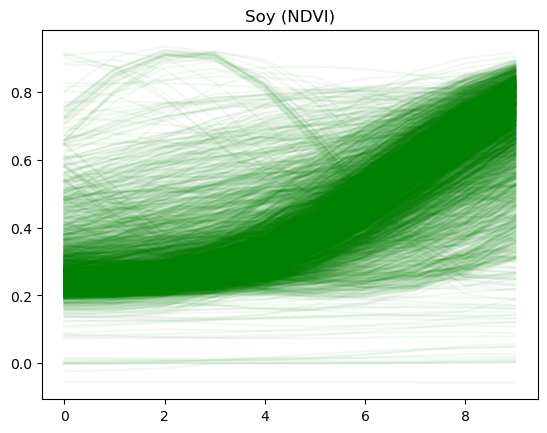

In [9]:
plt.title("Soy (NDVI)")
soy = np.in1d(y_19, 1)
plt.plot(
    X_19[soy, :][:, np.arange(8, X_19.shape[1], 9)].T, alpha=0.05, c="green"
)
plt.show()

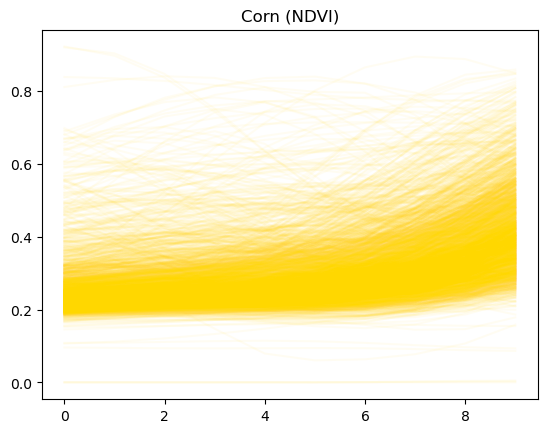

In [10]:
plt.title("Corn (NDVI)")
corn = np.in1d(y_19, 5)
plt.plot(
    X_19[corn, :][:, np.arange(8, X_19.shape[1], 9)].T, alpha=0.05, c="gold"
)
plt.show()

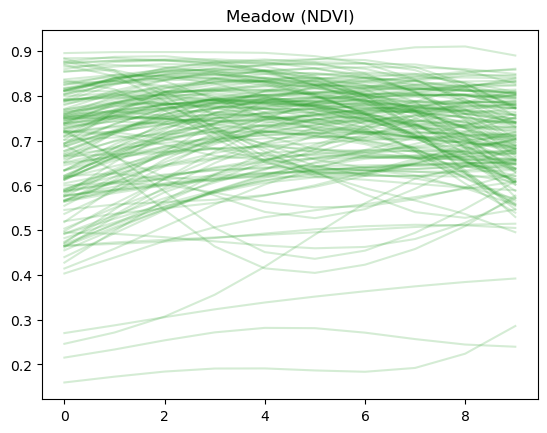

In [11]:
plt.title("Meadow (NDVI)")
meadow = np.in1d(y_19, 176)
plt.plot(
    X_19[meadow, :][:, np.arange(8, X_19.shape[1], 9)].T, alpha=0.2, c="C2"
)
plt.show()

As you can see there can be a high standard deviation for the same crop among fields. But we clearly see that the soy crop starts his growing phase earlier than the corn. Also, as the CSB is a predicted model, we can guess that it has some mislabelling where some crops don't have any growing phase. 

# Machine Learning
We use Random Forest and XGBoost to train with one or two years, and to **predict on year 2019**.

In [12]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()  # default parameters

Or use xgboost

In [13]:
import xgboost as xgb

model = xgb.XGBClassifier()

In [14]:
# class are not following number (they are like 1,5,205)... Torch and xgb needs following numbers (0,1,2,3)
y_18 = utils.y_to_range(y_18)
y_19 = utils.y_to_range(y_19)
y_20 = utils.y_to_range(y_20)

In [15]:
# confusion matrix kwargs
cm_plot_kwargs = dict(
    display_labels=list(utils.y_labels.values()),
    cmap="Blues",
    xticks_rotation="vertical",
    colorbar=False,
)

Score when training with 2018 : 0.6523076923076923


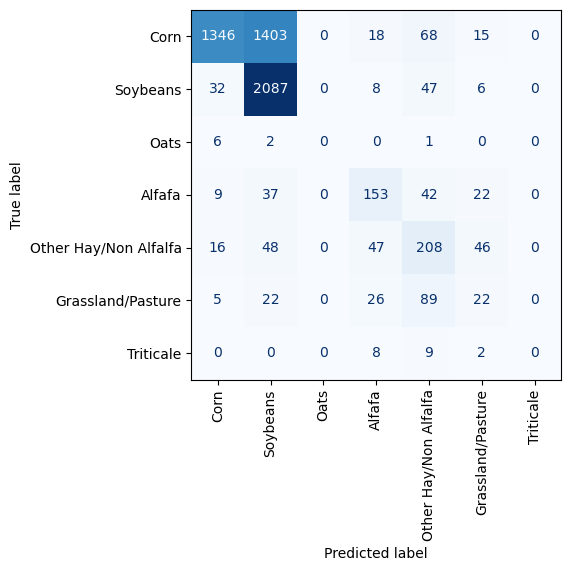

In [16]:
model.fit(X_18, y_18)
y_pred = model.predict(X_19)
score = metrics.accuracy_score(y_19, y_pred)
print(f"Score when training with 2018 : {score}")
y_pred_19 = model.predict(X_19)
metrics.ConfusionMatrixDisplay.from_predictions(
    y_19, y_pred, **cm_plot_kwargs
)

The purpose of the hackathon is to identify the main crops in preseason, here **Corn** and **Soybeans**. So the main idea is to lower the confusion between these two classes.
Here **1420 corn fields** have been predicted as **soybeans**, whereas only **37 soybeans** were predicted as **corn**. So here we overpredict the soybeans and underpredict the corn.

Score when training with 2020 : 0.7697435897435897


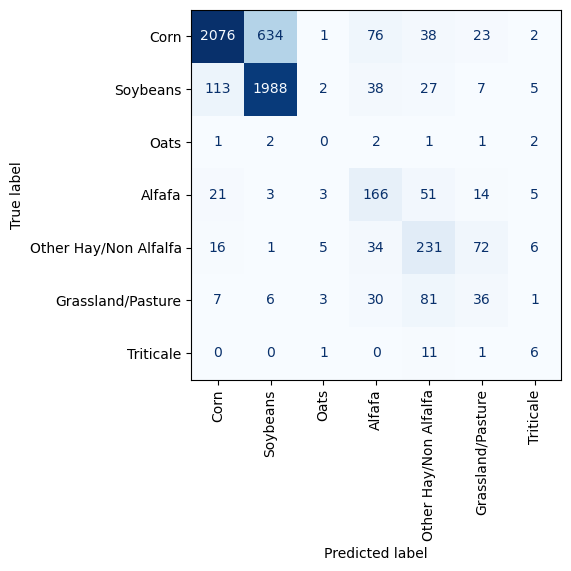

In [17]:
model.fit(X_20, y_20)
y_pred = model.predict(X_19)
score = metrics.accuracy_score(y_19, y_pred)
print(f"Score when training with 2020 : {score}")
metrics.ConfusionMatrixDisplay.from_predictions(
    y_19, y_pred, **cm_plot_kwargs
)

Score when training with 2018 and 2020 : 0.7488888888888889


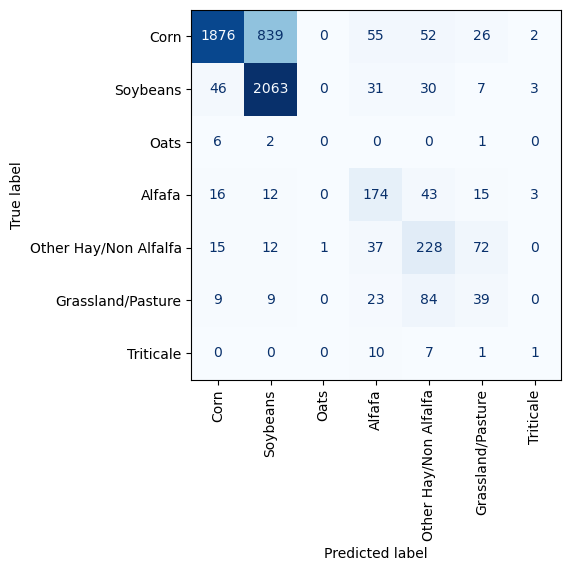

In [18]:
model.fit(np.vstack((X_18, X_20)), np.hstack((y_18, y_20)))
y_pred = model.predict(X_19)
score = metrics.accuracy_score(y_19, y_pred)
print(f"Score when training with 2018 and 2020 : {score}")
metrics.ConfusionMatrixDisplay.from_predictions(
    y_19, y_pred, **cm_plot_kwargs
)

# Deep Learning (RNN) : ELECTS model
ELECTS is a RNN algorithm which stands for : End-to-End Learned Early Classification of Time Series for In-Season Crop Type Mapping.
This model takes as input an array using *n* dates and *n* dimensions per date. So if you want to add a feature (like SAR data), you need to add for the a feature for each of the *n* dates.

You can see the ELECTS github page for more information : [ELECTS github](https://github.com/MarcCoru/elects/)

In [19]:
import elects

# We must define the number of bands
n_bands = 9  # (8 VNIR) + NDVI

In [20]:
train_ds = utils.torch_dataset(X_18, y_18, n_bands=n_bands)
test_ds = utils.torch_dataset(X_19, y_19, n_bands=n_bands)

model = elects.train(
    train_ds,
    test_ds,
    n_classes=len(utils.y_labels),
    epochs=100,
    n_bands=n_bands,
)

epoch 37: trainloss 0.37, testloss 4.62, accuracy 0.55, earliness 0.42. classification loss 12.37, earliness reward 3.1

stopping training. testloss 4.62 did not improve in 30 epochs.


Score when training with 2018 : 0.5497435897435897


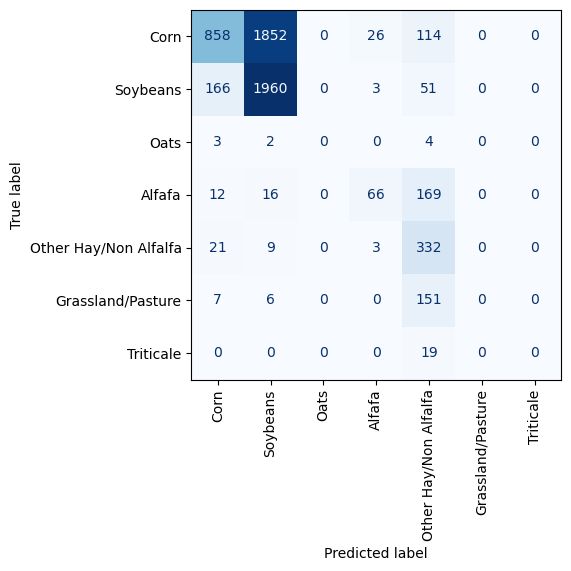

In [21]:
y_pred = model.predict(utils.x_to_torch(X_19, n_bands))[2].detach().numpy()

score = metrics.accuracy_score(y_19, y_pred)
print(f"Score when training with 2018 : {score}")

metrics.ConfusionMatrixDisplay.from_predictions(
    y_19, y_pred, **cm_plot_kwargs
)

# Train with two years

We want to train using 2 years in order to predict year 2019. We have two solutions, to resume from the previous model the training and just train with 2020, or to train a new model using 2018 and 2020 years at once.

resuming from snapshots/model.pth epoch 6


epoch 153: trainloss 0.61, testloss 1.69, accuracy 0.65, earliness 0.76. classification loss 7.38, earliness reward 4.0


stopping training. testloss 1.69 did not improve in 30 epochs.
Score when training with 2018 and 2020 : 0.6531623931623932


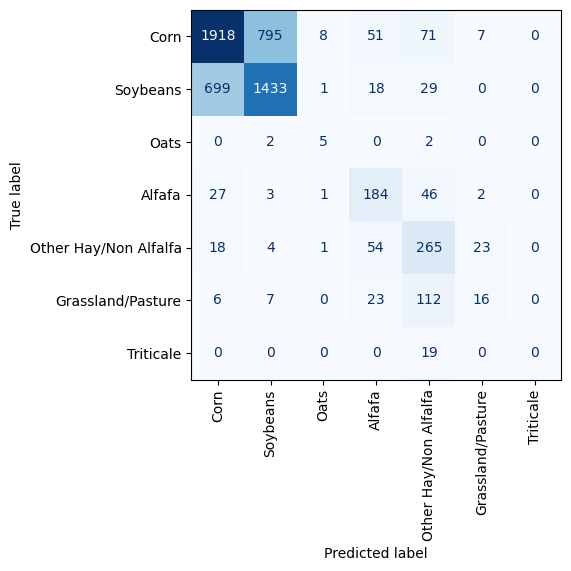

In [22]:
resume = True
# if resume, just add 2020 and use previous trained model
if resume:
    train_ds = utils.torch_dataset(X_20, y_20, n_bands=n_bands)
else:
    train_ds = utils.torch_dataset(
        np.vstack((X_18, X_20)), np.hstack((y_18, y_20)), n_bands=n_bands
    )

model = elects.train(
    train_ds,
    test_ds,
    n_classes=len(utils.y_labels),
    epochs=200,  # add 100 epochs
    n_bands=n_bands,
    resume=resume,  # in order to start using previous training
)

y_pred = model.predict(utils.x_to_torch(X_19, n_bands))[2].detach().numpy()

score = metrics.accuracy_score(y_19, y_pred)
print(f"Score when training with 2018 and 2020 : {score}")

metrics.ConfusionMatrixDisplay.from_predictions(
    y_19, y_pred, **cm_plot_kwargs
)

# Add new features to your samples

## Add global feature (one identical feature for all samples)

Let's suppose you find some global weather information (the same information for each of the feature) and you want to learn also with these informations.
You can add them with the `utils.add_features_on_X`. If you want to add a local feature (one specific feature for each field), you need to modify the behavior the this function.

In [23]:
print(f"My 2018 dataset has shape of {X_18.shape}")
n_bands = 9
n_dates = int(X_18.shape[1] / n_bands)

My 2018 dataset has shape of (7634, 90)


In [24]:
# Now we can add for each date a new feature
X_18_enhanced = utils.add_features_on_X(
    X_18, features=np.random.randint(0, 100, n_dates), n_dates=n_dates
)  # here we add random values from 0 to 100
print(
    f"My new feature for the first date of the first sample is : {X_18_enhanced[0,9]}"
)

My new feature for the first date of the first sample is : 5.0


In [25]:
# And you can add as many features as you want, they just need to have the same length as the number of dates
X_18_enhanced = utils.add_features_on_X(
    X_18_enhanced,
    features=np.random.randint(0, 100, n_dates),
    n_dates=n_dates,
)

print(f"X_18_enhanced has now {X_18_enhanced.shape[1]/10} features per date")

X_18_enhanced has now 11.0 features per date


## Add Sentinel-1 features per each sample

/!\ As ELECTS (Deep Learning part) requires a new feature at every time dimension, this approach will be mainly suitable only for the Machine Learning.
 


In [26]:
eds = earthdatastore.Auth()

year = 2018
s1_datacube = eds.datacube(
    "sentinel-1-rtc",
    bbox=bbox,
    datetime=[f"{year}-05-15", f"{year}-07-01"])

s1_zonal_stats = earthdatastore.cube_utils.zonal_stats_numpy(s1_datacube, utils.crops_layer(year).loc[y_18_indices])
s1_numpy = s1_zonal_stats.sel(stats="mean").to_array().to_numpy().reshape(-1,s1_zonal_stats.feature.size).T
X_18_with_s1 = np.hstack((X_18,s1_numpy))

vv: 100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [00:53<00:00,  6.68s/it]
